In [1]:
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from os.path import join as oj
import sys
sys.path.append('../vision_fit')
import numpy as np
from copy import deepcopy
import pickle as pkl
from torch.optim.lr_scheduler import StepLR
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise
import matplotlib.pyplot as plt
import models
from dim_reduction import *
%load_ext autoreload
%autoreload 2

# reduce model by projecting onto pcs that explain "percent_to_explain"
def reduce_model(model, percent_to_explain=0.85):
    model_r = deepcopy(model)
    weight_dict = model_r.state_dict()
    weight_dict_new = deepcopy(model_r.state_dict())
#     print(weight_dict)
    for layer_name in weight_dict.keys():
        if 'weight' in layer_name:
            w = weight_dict[layer_name]
            
            # get number of components
            pca = PCA(n_components=w.shape[1])
            pca.fit(w)
            explained_vars = pca.explained_variance_ratio_
            dim, perc_explained = 0, 0
            while perc_explained <= percent_to_explain:
                perc_explained += explained_vars[dim]
                dim += 1
            
            # actually project
            pca = PCA(n_components=dim)            
            w2 = pca.inverse_transform(pca.fit_transform(w))
            print('shapes', w.shape, w2.shape)
            weight_dict_new[layer_name] = torch.Tensor(w2)
            
    model_r.load_state_dict(weight_dict_new)
    return model_r

             
modelm = models.MnistNet()        
modelr = reduce_model(modelm)
convnet = models.LeNet()
linnet = models.LinearNet(28*28, 4, 256, 10)
ms = [modelm, modelr, convnet, linnet]

shapes torch.Size([500, 784]) (500, 784)
shapes torch.Size([256, 500]) (256, 500)
shapes torch.Size([10, 256]) (10, 256)


In [12]:
# for m in ms:
#     print(models.get_weight_names(m))
optim.SGD([x[1] for x in linnet.named_parameters()], lr=0.1)

In [ ]:
for key, value in dict(linnet.named_parameters()).items():
    print(key)

In [ ]:
a = [x[1] for x in linnet.named_parameters()]
# print([type(b) for b in a])
print([b.requires_grad for b in a])

In [3]:
x = Variable(torch.Tensor(np.random.rand(1, 3, 224, 224)), requires_grad=True)
# a = models.Linear_then_AlexNet()
a.forward(x)

NameError: name 'a' is not defined

In [13]:
weight_dict = deepcopy({x[0]:x[1].data.cpu().numpy() for x in a.named_parameters()})
print(weight_dict.keys(), a.state_dict().keys())

dict_keys(['features.6.bias', 'features.6.weight', 'features.0.weight', 'features.10.weight', 'features.3.weight', 'features.10.bias', 'classifier.1.weight', 'classifier.6.weight', 'classifier.1.bias', 'classifier.4.weight', 'features.8.weight', 'features.8.bias', 'features.0.bias', 'classifier.4.bias', 'classifier.6.bias', 'features.3.bias']) odict_keys(['features.0.weight', 'features.0.bias', 'features.3.weight', 'features.3.bias', 'features.6.weight', 'features.6.bias', 'features.8.weight', 'features.8.bias', 'features.10.weight', 'features.10.bias', 'classifier.1.weight', 'classifier.1.bias', 'classifier.4.weight', 'classifier.4.bias', 'classifier.6.weight', 'classifier.6.bias'])


In [5]:
# print(get_first_weight(modelm))
print(models.get_weight_names(m2)[0])

fc.0.weight
conv1.weight


In [26]:
from params_vision import p
np.random.seed(p.seed) 
torch.manual_seed(p.seed)    
use_cuda = torch.cuda.is_available()

batch_size = 100
root = oj('/scratch/users/vision/yu_dl/raaz.rsk/data', p.dset)
if not os.path.exists(root):
    os.mkdir(root)


## load mnist dataset     

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
train_set = dset.MNIST(root=root, train=True, transform=trans, download=True)
test_set = dset.MNIST(root=root, train=False, transform=trans, download=True)


ex_nums = {}
i = 0
while(len(ex_nums) < 10):
    ex_nums[train_set.train_labels[i]] = i
    i += 1
    
exs = np.zeros((10, 28, 28))
for i in range(10):
    exs[i] = train_set.train_data[i]
    
# train_set.train_data = torch.Tensor(exs)
# train_set.train_labels = torch.Tensor(np.arange(0, 10)).long()

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)
model = models.MnistNet()  
if use_cuda:
    model = model.cuda()



In [27]:
Y_train = np.array(train_set.train_labels)

In [31]:
for i in range(10):
    Y_big[:, i] = np.array(Y_train==i)

In [38]:
(Y_big/np.sum(Y_big, axis=0)).shape

(60000, 10)

In [41]:
np.arange(9).reshape((3, 3)) / np.arange(1, 4)

array([[0.        , 0.5       , 0.66666667],
       [3.        , 2.        , 1.66666667],
       [6.        , 3.5       , 2.66666667]])

In [20]:
print(train_set.train_labels)


 5
 0
 4
⋮ 
 5
 6
 8
[torch.LongTensor of size 60000]



In [29]:
ex_nums = {}
i = 0
while(len(ex_nums) < 10):
    ex_nums[train_set.train_labels[i]] = i
    i += 1
    
exs = np.zeros((10, 28, 28))
for i in range(10):
    exs[i] = train_set.train_data[i]
    
train_set.train_data = torch.Tensor(exs)
train_set.train_labels = torch.Tensor(np.arange(0, 10)).long()
print(train_set.train_data.shape, train_set.train_labels)
# train_set.train_labels = torch.Tensor(np.random.randint(0, 10, 60000)).long()
# train_set.train_labels

torch.Size([10, 28, 28]) 
 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
[torch.LongTensor of size 10]



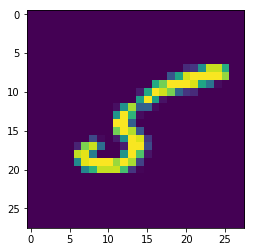

In [24]:
plt.imshow(train_set.train_data[11])

In [2]:
train_set.train_data.shape

NameError: name 'train_set' is not defined

In [10]:
d = torch.Tensor(np.random.randn(60000, 28, 28))
print(d.shape)

torch.Size([60000, 28, 28])


In [12]:
train_set.train_labels = torch.Tensor(np.random.randint(0, 10, 60000)).long()

In [14]:
np.random.randint(0, 10, 60000)

array([8, 8, 4, ..., 6, 0, 1])

In [37]:
test_set.

torch.Size([10000, 8, 8])


5
13


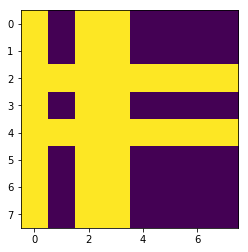

In [38]:
plt.imshow(bars[0])
print(labs[0])
print(np.max(labs))

In [10]:
root = oj('/scratch/users/vision/yu_dl/raaz.rsk/data', 'cifar10')
train_set = dset.CIFAR10(root=root, train=True, download=True, transform=trans)

Files already downloaded and verified


In [14]:
len(train_set.train_labels), type(train_set.train_labels[0])

(50000, int)

In [7]:
print(filter(lambda p: p.requires_grad, m.parameters()))


In [3]:
optimizer = optim.SGD(filter(lambda p: p.requires_grad, modelm.parameters()), lr=2)

In [7]:
for param_group in optimizer.param_groups:
        param_group['lr'] = 3

In [8]:
for param_group in optimizer.param_groups:
        print(param_group['lr'])

3
